In [2]:
# import libraries
import math
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
import plotly.express as px
import plotly.graph_objects as go

In [3]:
#Read the Yale Bright Star Catalog and create a Pandas data frame object.
df = pd.read_csv('bsc5.csv')

In [4]:
#Drop all objects that do not have a trigonometric parallax.
df = df.drop('Name', axis=1)
df = df.drop('DM', axis=1)
df = df.drop('HD', axis=1)
df = df.drop('SAO', axis=1)
df = df.drop('FK5', axis=1)
df = df.drop('IRflag', axis=1)
df = df.drop('r_IRflag', axis=1)
df = df.drop('Multiple', axis=1)
df = df.drop('ADS', axis=1)
df = df.drop('ADScomp', axis=1)
df = df.drop('VarID', axis=1)
df = df.drop('RAh1900', axis=1)
df = df.drop('RAm1900', axis=1)
df = df.drop('RAs1900', axis=1)
df = df.drop('DE-1900', axis=1)
df = df.drop('DEd1900', axis=1)
df = df.drop('DEm1900', axis=1)
df = df.drop('DEs1900', axis=1)
df = df.drop('GLON', axis=1)
df = df.drop('GLAT', axis=1)
df = df.drop('Vmag', axis=1)
df = df.drop('n_Vmag ', axis=1)
df = df.drop('u_Vmag', axis=1)
df = df.drop('B-V', axis=1)
df = df.drop('u_B-V', axis=1)
df = df.drop('U-B ', axis=1)
df = df.drop('u_U-B', axis=1)
df = df.drop('R-I', axis=1)
df = df.drop('n_R-I', axis=1)
df = df.drop('n_SpType', axis=1)
df = df.drop('pmRA', axis=1)
df = df.drop('pmDE', axis=1)
df = df.drop('n_Parallax', axis=1)
df = df.drop('n_RadVel', axis=1)
df = df.drop('l_RotVel', axis=1)
df = df.drop('RotVel', axis=1)
df = df.drop('u_RotVel', axis=1)
df = df.drop('Dmag', axis=1)
df = df.drop('Sep', axis=1)
df = df.drop('MultID', axis=1)
df = df.drop('MultCnt', axis=1)
df = df.drop('NoteFlag', axis=1)
df = df.drop(df.columns[df.columns.str.contains('Unnamed', case=False)], axis=1)

df['Parallax'] = df['Parallax'].replace('     ', np.nan)
df['Parallax'] = df['Parallax'].replace('    -', np.nan)
df['Parallax'] = df['Parallax'].replace('.015-', np.nan)
df.dropna(subset=['Parallax'], inplace=True)
df.reset_index(drop = True, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3293 entries, 0 to 3292
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   HR        3293 non-null   int64 
 1   RAh       3293 non-null   object
 2   RAm       3293 non-null   object
 3   RAs       3293 non-null   object
 4   DE-       3293 non-null   object
 5   DEd       3293 non-null   object
 6   DEm       3293 non-null   object
 7   DEs       3293 non-null   object
 8   SpType    3293 non-null   object
 9   Parallax  3293 non-null   object
 10  RadVel    3293 non-null   object
dtypes: int64(1), object(10)
memory usage: 283.1+ KB


In [5]:
#Create a column called Distance that has the distance of the object in parsec. 
#Remember that the inverse of the parallax in arc_seconds is the distance in parsec.
df['Parallax'] = pd.to_numeric(df['Parallax'], errors='coerce')
def inverse(parallax):
    if parallax != 0:
        parsec = 1 / parallax
        return parsec
    else:
        return None
df['Distance'] = df['Parallax'].apply(inverse)
#df.head()

In [6]:
#Use the RA and Dec for the J2000.0 epoch for the next set of computations.
#Create three columns x, y, and z that will have the distances to the stars in parsecs in the equatorial frame of reference. 
#Write a routine that will do a coordinate transformation from a spherical coordinate system to a Cartesian system. 
#In this Cartesian system, the x-axis is pointing to the vernal equinox and the x-y plane is the plane of the celestial equator. 
#The z-axis should be pointing to the north celestial pole. You can use the library Astropy for your work.

#Using the RA
df['RAh'] = pd.to_numeric(df['RAh'], errors='coerce')
df['RAm'] = pd.to_numeric(df['RAm'], errors='coerce')
df['RAs'] = pd.to_numeric(df['RAs'], errors='coerce')

def ra_decimal_degrees(rah, ram, ras):
    RA_sum = rah + ram/60 + ras/3600
    RA = 15 * RA_sum 
    return RA
df['ra'] = df.apply(lambda row: ra_decimal_degrees(row['RAh'], row['RAm'], row['RAs']), axis=1)

#Using the Dec
df['DEd'] = pd.to_numeric(df['DEd'], errors='coerce')
df['DEm'] = pd.to_numeric(df['DEm'], errors='coerce')
df['DEs'] = pd.to_numeric(df['DEs'], errors='coerce')

def dec_decimal_degrees(sign, DEd, DEm, DEs):
    dec_sum = DEd + DEm/60 + DEs/3600
    if sign == '-':
        dec = -dec_sum 
        return dec
    else:
        return dec_sum
df['dec'] = df.apply(lambda row: dec_decimal_degrees(row['DE-'], row['DEd'], row['DEm'], row['DEs']), axis=1)


coords = SkyCoord(ra = df['ra'], dec = df['dec'], unit = (u.deg, u.deg), frame = 'icrs')
equatorial_coords = coords.transform_to('icrs')

df['x'] = equatorial_coords.cartesian.x.value
df['y'] = equatorial_coords.cartesian.y.value
df['z'] = equatorial_coords.cartesian.z.value
#df.head()

In [10]:
#Create a column called Color in your data frame. The colors could be named colors like red or blue. 
#Or, the colors could be in hexadecimal format. 
#Here is the color scheme according to spectral types - 
#O (deepest blue), B (medium blue), A (light blue), F (green), G (yellow), K (orange), M (red), 
#and any other star not having a spectral type black.

color_dict = {
    "O": "blueviolet",
    "B": "mediumblue",
    "A": "lightblue",
    "F": "limegreen",
    "G": "gold",
    "K": "darkorange",
    "M": "red",
    "else": "black"
}
def color(sptype):
    first_letter = next((char for char in sptype if char.isupper()), None)
    if first_letter == "O":
        return first_letter
    elif first_letter == "B":
        return first_letter
    elif first_letter == "A":
        return first_letter
    elif first_letter == "F":
        return first_letter
    elif first_letter == "G":
        return first_letter
    elif first_letter == "K":
        return first_letter
    elif first_letter == "M":
        return first_letter
    else:
        return "else"
df['Color'] = df['SpType'].map(lambda x: color_dict.get(color(x), 'default_color'))
df.head()

,HR,RAh,RAm,RAs,DE-,DEd,DEm,DEs,SpType,Parallax,RadVel,Distance,ra,dec,x,y,z,Color
0,3,0,5,20.1,-,5,42,27,K0IIIbCN-0.5,0.014,-6,71.428571,1.333750,-5.707500,0.994773,0.023161,-0.099450,darkorange
1,5,0,6,16.0,+,58,26,12,G5V,0.047,-12,21.276596,1.566667,58.436667,0.523245,0.014311,0.852062,gold
2,6,0,6,19.0,-,49,4,30,G1IV,0.050,3,20.000000,1.579167,-49.075000,0.654822,0.018053,-0.755568,gold
3,8,0,6,36.8,+,29,1,17,K0V,0.067,-8,14.925373,1.653333,29.021389,0.874075,0.025229,0.485136,darkorange
4,15,0,8,23.3,+,29,5,26,B8IVpMnHg,0.032,-12,31.250000,2.097083,29.090556,0.873267,0.031977,0.486191,mediumblue


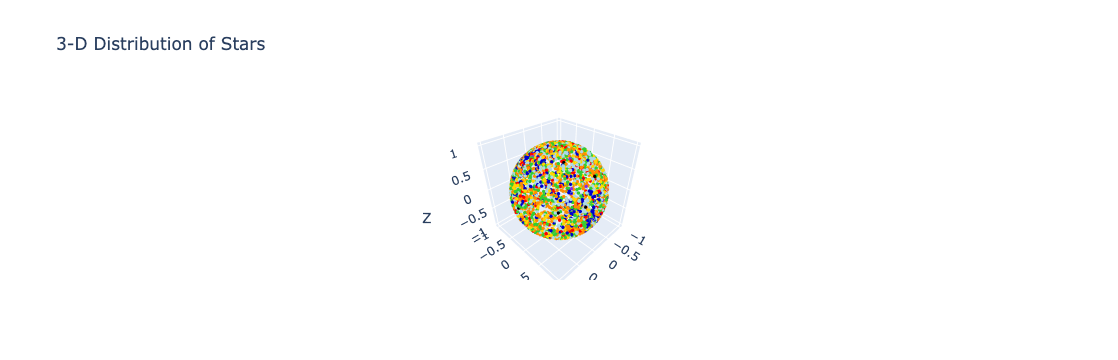

In [14]:
#Use Plotly to obtain the 3-D distribution of the stars.
#The stars should be color-coded.
#If you hover over a star, you should get the following information - HR Number, Distance in parsec, and Radial Velocity in km/s.  

fig = go.Figure(data=[go.Scatter3d(x = df['x'], y = df['y'], z = df['z'], mode = 'markers', marker = dict(size = 2, color = df['Color']), 
                                   text=df.apply(lambda row: f"HR Number: {row['HR']}"f"Distance: {row['Distance']} parsecs"f"Radial Velocity: {row['RadVel']} km/s", 
                                                 axis=1))])
fig.update_layout(scene = dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',), 
                  title = '3-D Distribution of Stars')
fig.show()